<a href="https://colab.research.google.com/github/erdult/automl/blob/main/autogluon_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# the goal here is to estimate next hour returns but only use data upto last month to train, and all last month is used for validation

In [ ]:
!pip install autogluon>=1.5.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rasterio 1.5.0 requires click!=8.2.*,>=4.0, but you have click 8.2.1 which is incompatible.


In [ ]:
import yfinance as yf


import os
import pickle

file_path = 'data.pkl'

if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    print("Data loaded from file.")
else:
    # Run your code to generate data here
    data = yf.download(
    "^GSPC",
    interval="1h",
    period="60d"
    )
    data = data.reset_index()

    with open(file_path, 'wb') as f:
        pickle.dump(data, f)
    print("File not found. Code executed and data saved.")


/tmp/ipython-input-4200066783.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed

File not found. Code executed and data saved.


In [ ]:
data.columns = ["timestamp", "close", "high", "low", "open", "volume"]
df = data.copy()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Assume df has columns: timestamp, open, high, low, close, volume ---


import numpy as np
# Compute hourly returns
# Target: hourly returns (stationary)

#return can be a variable and also target, as target is 1d ahead return
df["return"] = df["close"].pct_change()
df["target"] = df["close"].pct_change()

df = df.dropna()

# Candle structure
df["range"] = df["high"] - df["low"]
df["body"] = df["close"] - df["open"]

# Volume dynamics
df["vol_change"] = df["volume"].pct_change()


# AutoGluon format
df["item_id"] = "SP500"
# Ensure timestamp is proper datetime64[ns] for AutoGluon
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# If timezone-aware, convert to UTC then remove tz info
if pd.api.types.is_datetime64tz_dtype(df['timestamp']):
    df['timestamp'] = df['timestamp'].dt.tz_convert('UTC').dt.tz_localize(None)

# Final check / cleanup
print('NaT count before drop:', df['timestamp'].isna().sum())
df = df.dropna(subset=['timestamp']).reset_index(drop=True)
print(df['timestamp'].dtype, df['timestamp'].head())


NaT count before drop: 0
datetime64[ns] 0   2025-10-20 14:30:00
1   2025-10-20 15:30:00
2   2025-10-20 16:30:00
3   2025-10-20 17:30:00
4   2025-10-20 18:30:00
Name: timestamp, dtype: datetime64[ns]


/tmp/ipython-input-1612232943.py:34: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df['timestamp']):


In [ ]:
df

,timestamp,close,high,low,open,volume,return,target,range,body,vol_change,item_id
0,2025-10-20 14:30:00,6730.770020,6736.229980,6720.520020,6725.169922,333227237,0.000849,0.000849,15.709961,5.600098,NaN,SP500
1,2025-10-20 15:30:00,6729.779785,6734.990234,6724.229980,6731.029785,268403249,-0.000147,-0.000147,10.760254,-1.250000,-0.194534,SP500
2,2025-10-20 16:30:00,6738.750000,6742.250000,6725.669922,6729.839844,220432000,0.001333,0.001333,16.580078,8.910156,-0.178728,SP500
3,2025-10-20 17:30:00,6740.580078,6744.350098,6738.129883,6738.629883,226434000,0.000272,0.000272,6.220215,1.950195,0.027228,SP500
4,2025-10-20 18:30:00,6739.160156,6741.970215,6734.330078,6740.520020,268615000,-0.000211,-0.000211,7.640137,-1.359863,0.186284,SP500
...,...,...,...,...,...,...,...,...,...,...,...,...
406,2026-01-14 16:30:00,6895.229980,6918.879883,6885.740234,6916.100098,334704000,-0.003025,-0.003025,33.139648,-20.870117,-0.132902,SP500
407,2026-01-14 17:30:00,6900.490234,6900.580078,6886.370117,6895.180176,280193000,0.000763,0.000763,14.209961,5.310059,-0.162863,SP500
408,2026-01-14 18:30:00,6905.270020,6907.120117,6887.180176,6900.490234,287518000,0.000693,0.000693,19.939941,4.779785,0.026143,SP500
409,2026-01-14 19:30:00,6915.459961,6920.319824,6897.600098,6905.319824,383088000,0.001476,0.001476,22.719727,10.140137,0.332397,SP500


In [ ]:
# Trading-session features
df["trade_date"] = df["timestamp"].dt.date
df["session_hour"] = df.groupby("trade_date").cumcount()
df["is_open"] = (df["session_hour"] == 0).astype(int)

In [ ]:
df

,timestamp,close,high,low,open,volume,return,target,range,body,vol_change,item_id
0,2025-10-20 14:30:00,6730.770020,6736.229980,6720.520020,6725.169922,333227237,0.000849,0.000849,15.709961,5.600098,NaN,SP500
1,2025-10-20 15:30:00,6729.779785,6734.990234,6724.229980,6731.029785,268403249,-0.000147,-0.000147,10.760254,-1.250000,-0.194534,SP500
2,2025-10-20 16:30:00,6738.750000,6742.250000,6725.669922,6729.839844,220432000,0.001333,0.001333,16.580078,8.910156,-0.178728,SP500
3,2025-10-20 17:30:00,6740.580078,6744.350098,6738.129883,6738.629883,226434000,0.000272,0.000272,6.220215,1.950195,0.027228,SP500
4,2025-10-20 18:30:00,6739.160156,6741.970215,6734.330078,6740.520020,268615000,-0.000211,-0.000211,7.640137,-1.359863,0.186284,SP500
...,...,...,...,...,...,...,...,...,...,...,...,...
406,2026-01-14 16:30:00,6895.229980,6918.879883,6885.740234,6916.100098,334704000,-0.003025,-0.003025,33.139648,-20.870117,-0.132902,SP500
407,2026-01-14 17:30:00,6900.490234,6900.580078,6886.370117,6895.180176,280193000,0.000763,0.000763,14.209961,5.310059,-0.162863,SP500
408,2026-01-14 18:30:00,6905.270020,6907.120117,6887.180176,6900.490234,287518000,0.000693,0.000693,19.939941,4.779785,0.026143,SP500
409,2026-01-14 19:30:00,6915.459961,6920.319824,6897.600098,6905.319824,383088000,0.001476,0.001476,22.719727,10.140137,0.332397,SP500


In [ ]:
#creating continues time series data
df['timestamp_original']  = df['timestamp']
df["session_index"] = range(len(df))
start_date = pd.Timestamp("2025-01-01 09:00:00")  # can be any date
df["timestamp"] = df["session_index"].apply(lambda x: start_date + pd.Timedelta(hours=x))

df["month"] = pd.to_datetime(df["timestamp_original"]).dt.to_period("M")
months = df["month"].unique()



In [ ]:
months

<PeriodArray>
['2025-10', '2025-11', '2025-12', '2026-01']
Length: 4, dtype: period[M]

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame
import pandas as pd




def rolling_backtest(train_ts, test_ts, known_covariates, predictor):
  rolling_preds = []

  current_ts = train_ts.copy()

  # Get unique timestamps in test month
  test_timestamps = test_ts.index.get_level_values("timestamp").unique()

  for ts in test_timestamps:
      # Known covariates for THIS hour
      covs_h = future_known_covariates.loc[
          future_known_covariates.index.get_level_values("timestamp") == ts
      ]
      # print(covs_h)

      best_model = predictor.model_best

      # 1-step prediction
      preds = predictor.predict(
          current_ts,
          known_covariates=covs_h,
          model = best_model
      )

      rolling_preds.append(preds)

      # Append TRUE observed values for THIS hour
      true_row = test_ts.loc[
          test_ts.index.get_level_values("timestamp") == ts
      ]

      current_ts = TimeSeriesDataFrame(
          pd.concat([current_ts, true_row])
      )
  return rolling_preds






In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

results = []

all_preds = []

for i in range(len(months) - 1):

    train_month = months[i]
    test_month  = months[i + 1]

    # history to train, next month predict, you can put window to history to limit the data if yo want
    train_df = df[df["month"] <= train_month].copy()
    test_df  = df[df["month"] == test_month].copy()

    train_df = train_df.drop(columns=["month"], errors="ignore")
    test_df  = test_df.drop(columns=["month"], errors="ignore")


    train_ts = TimeSeriesDataFrame.from_data_frame(
        train_df,
        id_column="item_id",
        timestamp_column="timestamp"
    )

    test_ts = TimeSeriesDataFrame.from_data_frame(
        test_df,
        id_column="item_id",
        timestamp_column="timestamp"
    )

    predictor = TimeSeriesPredictor(
        target="target",
        prediction_length=1,  # next hour
        eval_metric="RMSE",
        known_covariates_names=["session_hour", "is_open"]
    )

    predictor.fit(
        train_ts,
        presets="medium_quality",
        hyperparameters={
            "TemporalFusionTransformer": {},
            "PatchTST": {}
        },
        time_limit=600
    )

    print(predictor.leaderboard())


    # Build Future Covariates Automatically
    future_times = test_df['timestamp'] + pd.Timedelta(hours=1)

    future_df = pd.DataFrame({
        "timestamp": future_times
    })

    future_df = test_df[['timestamp', 'item_id', "session_hour", "is_open"]].copy()

    from autogluon.timeseries import TimeSeriesDataFrame

    future_known_covariates = TimeSeriesDataFrame.from_data_frame(
        future_df,
        id_column="item_id",
        timestamp_column="timestamp"
    )


    preds = rolling_backtest(train_ts, test_ts, future_known_covariates, predictor)


    merged = test_df.merge(
        pd.concat(preds).reset_index()[["timestamp", "mean"]],
        on="timestamp",
        how="left"
    )

    merged["train_month"] = str(train_month)
    merged["test_month"]  = str(test_month)

    all_preds.append(merged)

    rmse = np.sqrt(((merged["target"] - merged["mean"])**2).mean())

    direction_acc = (
        (merged["target"] > 0) == (merged["mean"] > 0)
    ).mean()

    results.append({
        "train_month": str(train_month),
        "test_month": str(test_month),
        "rmse": rmse,
        "direction_acc": direction_acc
    })



results_df = pd.DataFrame(results)
print(results_df)


No path specified. Models will be saved in: "AutogluonModels/ag-20260114_213241"
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/AutogluonModels/ag-20260114_213241'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Pytorch Version:    2.9.0+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 14.73/14.74 GB
Total GPU Memory:   Free: 14.73 GB, Allocated: 0.01 GB, Total: 14.74 GB
GPU Count:          1
Memory Avail:       9.44 GB / 12.67 GB (74.5%)
Disk Space Avail:   73.06 GB / 112.64 GB (64.9%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'PatchTST': {}, 'TemporalFusionTransformer': {}},
 'known_covariates_names': ['session_hour', 'is_open'],
 'num_val_windows': 1,
 'predict

                       model  score_val  pred_time_val  fit_time_marginal  \
0           WeightedEnsemble  -0.002441       0.016964           0.087766   
1                   PatchTST  -0.002441       0.016451          21.094212   
2  TemporalFusionTransformer  -0.004340       0.027568          53.255187   

   fit_order  
0          3  
1          2  
2          1  


No path specified. Models will be saved in: "AutogluonModels/ag-20260114_213407"
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/AutogluonModels/ag-20260114_213407'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Pytorch Version:    2.9.0+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 14.73/14.74 GB
Total GPU Memory:   Free: 14.73 GB, Allocated: 0.01 GB, Total: 14.74 GB
GPU Count:          1
Memory Avail:       9.52 GB / 12.67 GB (75.1%)
Disk Space Avail:   73.06 GB / 112.64 GB (64.9%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'PatchTST': {}, 'TemporalFusionTransformer': {}},
 'known_covariates_names': ['session_hour', 'is_open'],
 'num_val_windows': 1,
 'predict

                       model  score_val  pred_time_val  fit_time_marginal  \
0           WeightedEnsemble  -0.000059       0.020004           0.085453   
1                   PatchTST  -0.000059       0.019433          28.075453   
2  TemporalFusionTransformer  -0.000297       0.027407          64.479132   

   fit_order  
0          3  
1          2  
2          1  


No path specified. Models will be saved in: "AutogluonModels/ag-20260114_213554"
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/AutogluonModels/ag-20260114_213554'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Pytorch Version:    2.9.0+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 14.73/14.74 GB
Total GPU Memory:   Free: 14.73 GB, Allocated: 0.01 GB, Total: 14.74 GB
GPU Count:          1
Memory Avail:       9.51 GB / 12.67 GB (75.1%)
Disk Space Avail:   73.06 GB / 112.64 GB (64.9%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'PatchTST': {}, 'TemporalFusionTransformer': {}},
 'known_covariates_names': ['session_hour', 'is_open'],
 'num_val_windows': 1,
 'predict

                       model  score_val  pred_time_val  fit_time_marginal  \
0           WeightedEnsemble  -0.000293       0.016566           0.089020   
1                   PatchTST  -0.000293       0.016011          17.016901   
2  TemporalFusionTransformer  -0.000476       0.043420          63.829894   

   fit_order  
0          3  
1          2  
2          1  
  train_month test_month      rmse  direction_acc
0     2025-10    2025-11  0.004473       0.503876
1     2025-11    2025-12  0.003096       0.460000
2     2025-12    2026-01  0.001957       0.523810


In [ ]:
predictor.model_best

'PatchTST'

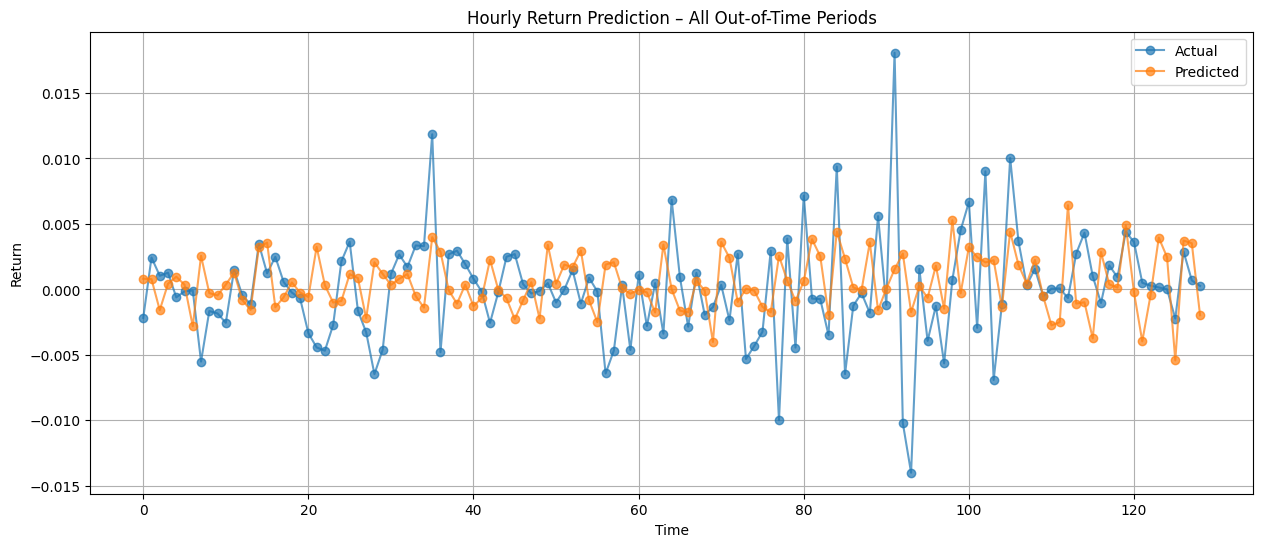

In [ ]:
all_preds_df = pd.concat(all_preds).sort_values("timestamp")

all_preds_df = all_preds_df.reset_index(drop=True)
all_preds_df["seq"] = range(len(all_preds_df))

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(all_preds_df["seq"], all_preds_df["target"], label="Actual", alpha=0.7,marker="o")
plt.plot(all_preds_df["seq"], all_preds_df["mean"], label="Predicted", alpha=0.7,marker="o")

plt.title("Hourly Return Prediction – All Out-of-Time Periods")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()


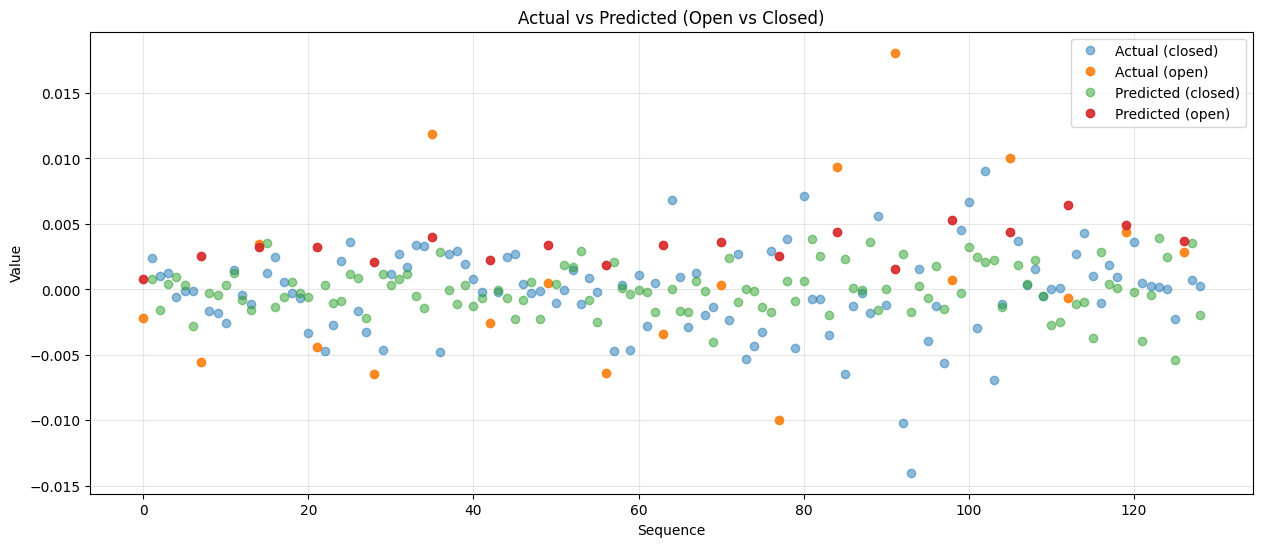

In [ ]:
mask_open = all_preds_df["is_open"] == 1
mask_closed = ~mask_open

plt.figure(figsize=(15, 6))

# Actual - closed
plt.plot(
    all_preds_df.loc[mask_closed, "seq"],
    all_preds_df.loc[mask_closed, "target"],
    label="Actual (closed)",
    alpha=0.5,
    marker="o",
    linestyle="None"
)

# Actual - open
plt.plot(
    all_preds_df.loc[mask_open, "seq"],
    all_preds_df.loc[mask_open, "target"],
    label="Actual (open)",
    alpha=0.9,
    marker="o",
    linestyle="None"
)

# Predicted - closed
plt.plot(
    all_preds_df.loc[mask_closed, "seq"],
    all_preds_df.loc[mask_closed, "mean"],
    label="Predicted (closed)",
    alpha=0.5,
    marker="o",
    linestyle="None"
)

# Predicted - open
plt.plot(
    all_preds_df.loc[mask_open, "seq"],
    all_preds_df.loc[mask_open, "mean"],
    label="Predicted (open)",
    alpha=0.9,
    marker="o",
    linestyle="None"
)

plt.legend()
plt.xlabel("Sequence")
plt.ylabel("Value")
plt.title("Actual vs Predicted (Open vs Closed)")
plt.grid(True, alpha=0.3)
plt.show()

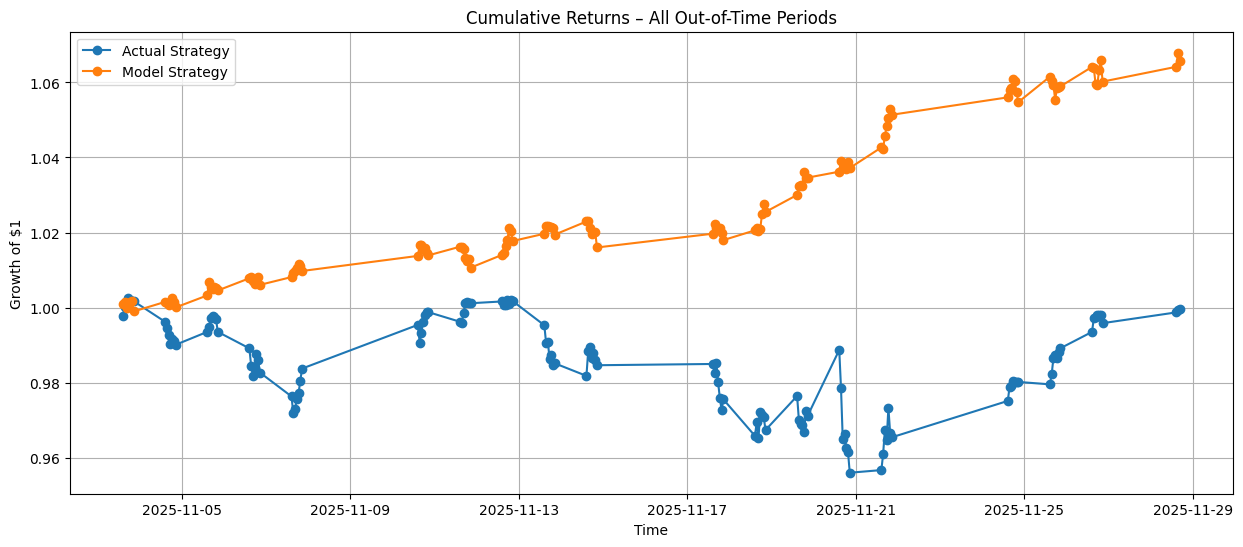

In [ ]:
all_preds_df["actual_cum"] = (1 + all_preds_df["target"]).cumprod()
all_preds_df["pred_cum"]   = (1 + all_preds_df["mean"]).cumprod()

plt.figure(figsize=(15, 6))
plt.plot(all_preds_df["timestamp_original"], all_preds_df["actual_cum"], label="Actual Strategy", marker="o")
plt.plot(all_preds_df["timestamp_original"], all_preds_df["pred_cum"], label="Model Strategy",marker="o")

plt.title("Cumulative Returns – All Out-of-Time Periods")
plt.xlabel("Time")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

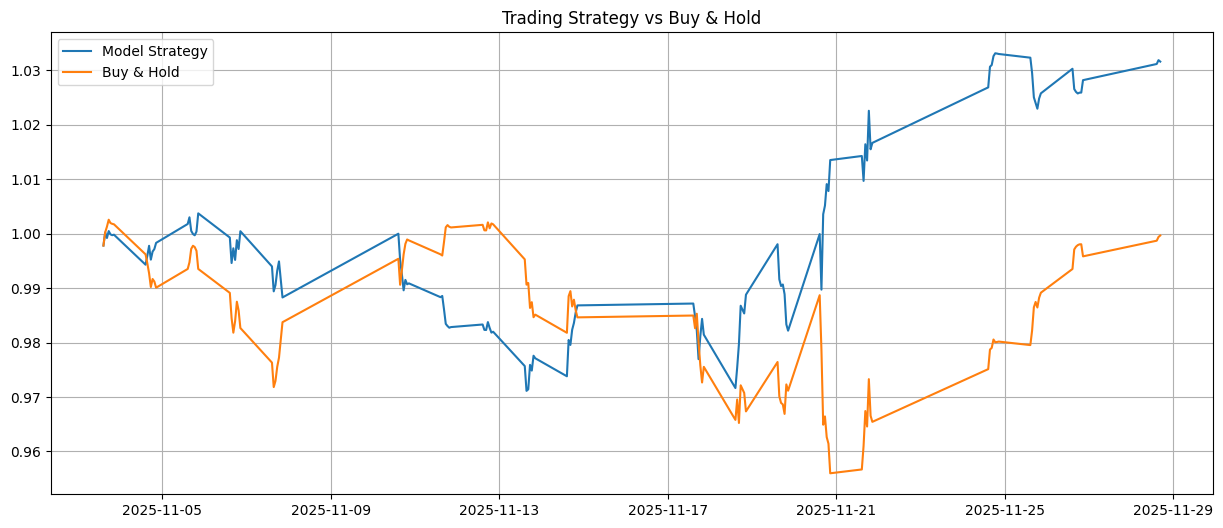

In [ ]:
all_preds_df["signal"] = np.sign(all_preds_df["mean"])
all_preds_df["strategy_return"] = all_preds_df["signal"] * all_preds_df["target"]

all_preds_df["strategy_cum"] = (1 + all_preds_df["strategy_return"]).cumprod()

plt.figure(figsize=(15, 6))
plt.plot(all_preds_df["timestamp_original"], all_preds_df["strategy_cum"], label="Model Strategy")
plt.plot(all_preds_df["timestamp_original"], all_preds_df["actual_cum"], label="Buy & Hold")

plt.title("Trading Strategy vs Buy & Hold")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predictor.leaderboard()
